In [1]:
!pip install tclab

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
pip install tclab --upgrade


The following command must be run outside of the IPython shell:

    $ pip install tclab --upgrade

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import numpy
import scipy
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
from tclab import TCLab, clock, Historian, Plotter, setup

### Parameters

In [63]:
t=numpy.linspace(0, 2500, 25000)
ksteel=16.3
σ=5.670*10**-8
hair=10
kepoxy=2.60
Ah=270**-4
As=7*10**-4
mh=0.004
ms=0.001
mf=0.01
mm=0.006
d_xm=0.001
d_xf=0.001
d_xe=0.00014
L=0.0019
thickness=0.001
w=0.01
Aexp=7*10**-6
Am=1.52*10**-5
Amback=1.52*10**-5
Af=3.9*10**-5
Afback=1.1*10**-5
ηfin=0.8689
M=35.0285
Lc=19.5*10**-3
Q11 = 300
Q22 = 65
hgap= 1900
Ti=293.15
n=5
ϵ=0.99
Cps=502.416

### Algebraic equations

In [64]:
Lc = L+thickness/2
Af = 2*w*Lc
M = numpy.sqrt(2*hair/(ksteel*thickness))
ηfin = numpy.tanh(M*Lc)/(M*Lc)

### Unit step response

In [74]:
def α1(t):
    if t<200:
        return 0
    else:
        return 40

def α2(t):
    if t<200:
        return 0
    else:
        return 0

### Differential equations

In [75]:
tspan=numpy.linspace(0,2500,25000)
def model(T,t): 
    TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o=T
    
    dTH1dt=(((-kepoxy*Ah*(TH1-TS1))/d_xe)-(hair*Ah*(TH1-Ti))-(hgap*Ah*(TH1-TM1i))-(ϵ*σ*Ah*(TH1**4-Ti**4))+α1(t)*Q11)/(mh*Cps)
    dTH2dt=(((-kepoxy*Ah*(TH2-TS2))/d_xe)-(hair*Ah*(TH2-Ti))-(hgap*Ah*(TH2-TM2i))-(ϵ*σ*Ah*(TH2**4-Ti**4))+α2(t)*Q22)/(mh*Cps)
    dTS1dt=(((kepoxy*Ah*(TH1-TS1))/d_xe)-(hair*As*(TS1-Ti))-(ϵ*σ*As*(TS1**4-Ti**4)))/(ms*Cps)
    dTS2dt=(((kepoxy*Ah*(TH2-TS2))/d_xe)-(hair*As*(TS2-Ti))-(ϵ*σ*As*(TS2**4-Ti**4)))/(ms*Cps)
    dTM1idt=(hgap*Ah*(TH1-TM1i)-(hair*Aexp*(TM1i-Ti))-(ϵ*σ*Aexp*(TM1i**4-Ti**4))+((-ksteel*Am*(TM1i-TM1o)/d_xm)))/(mm*Cps)
    dTM2idt=(hgap*Ah*(TH2-TM2i)-(hair*Aexp*(TM2i-Ti))-(ϵ*σ*Aexp*(TM2i**4-Ti**4))+((-ksteel*Am*(TM2i-TM2o)/d_xm)))/(mm*Cps)    
    dTM1odt=((ksteel*Am*(TM1i-TM1o)/d_xm)-(hair*Amback*(TM1o-TF1i)))/(mm*Cps)
    dTM2odt=((ksteel*Am*(TM2i-TM2o)/d_xm)-(hair*Amback*(TM2o-TF2i)))/(mm*Cps)
    dTF1idt=((hair*Amback*(TM1o-TF1i))-(ksteel*Afback*(TF1i-TF1o)/d_xf))/(mf*Cps)
    dTF2idt=((hair*Amback*(TM2o-TF2i))-(ksteel*Afback*(TF2i-TF2o)/d_xf))/(mf*Cps)
    dTF1odt=((ksteel*Afback*(TF1i-TF1o)/d_xf)-(hair*Afback*(TF1o-Ti))-(ϵ*σ*Afback*(TF1o**4-Ti**4))-(n*ηfin*hair*Af*(TF1o-TF2o))-(n*ηfin*hair*Af*(TF1o-Ti))+(n*ηfin*hair*Af*(TF2o-TF1o)-(n*ηfin*ϵ*σ*Af*(TF1o**4-Ti**4))))/(mf*Cps)
    dTF2odt=((ksteel*Afback*(TF2i-TF2o)/d_xf)-(hair*Afback*(TF2o-Ti))-(ϵ*σ*Afback*(TF2o**4-Ti**4))-(n*ηfin*hair*Af*(TF2o-TF1o))-(n*ηfin*hair*Af*(TF2o-Ti))+(n*ηfin*hair*Af*(TF1o-TF2o)-(n*ηfin*ϵ*σ*Af*(TF2o**4-Ti**4))))/(mf*Cps) 
    return dTH1dt,dTH2dt,dTS1dt,dTS2dt,dTM1idt,dTM2idt,dTM1odt,dTM2odt,dTF1idt,dTF2idt,dTF1odt,dTF2odt


### Eulers integration method for unit step response

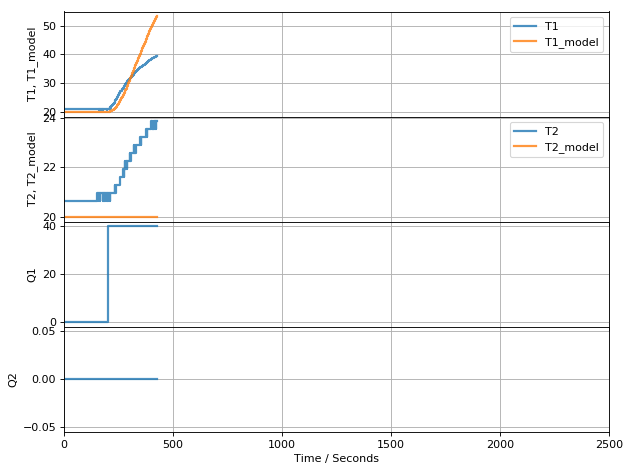

TCLab Model disconnected successfully.


KeyboardInterrupt: 

In [76]:
TCLab = setup(connected = False, speedup=1000)
with TCLab() as lab:
    h5 = Historian(lab.sources +[('T1_model', lambda:To[2]-273.15),('T2_model', lambda:To[3]-273.15)])
    p = Plotter(h5,2500, layout=(('T1','T1_model'),('T2','T2_model'),('Q1',),('Q2',),))
    dt= 0.35
    To=[20+273.15, 20+273.15, 20+273.15, 20+273.15,20+273.15,20+273.15,20+273.15,20+273.15,20+273.15,20+273.15,20+273.15,20+273.15 ]
    TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o=To


    for t in clock(2500):
        Q1 = α1(t)
        Q2 = α2(t)
        lab.Q1(Q1)
        lab.Q2(Q2)

        To = TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o
        dTH1dt,dTH2dt,dTS1dt,dTS2dt,dTM1idt,dTM2idt,dTM1odt,dTM2odt,dTF1idt,dTF2idt,dTF1odt,dTF2odt= model(To, t)
    
        TH1+=dTH1dt*dt
        TH2+=dTH2dt*dt
        TS1+=dTS1dt*dt
        TS2+=dTS2dt*dt
        TM1i+=dTM1idt*dt
        TM2i+=dTM2idt*dt
        TM1o+=dTM1odt*dt
        TM2o+=dTM2odt*dt
        TF1i+=dTF1idt*dt
        TF2i+=dTF2idt*dt
        TF1o+=dTF1odt*dt
        TF2o+=dTF2odt*dt
        
        To = TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o
        h5.update(t)
        p.update(t)

### Rectangular step response

In [ ]:
def α1(t):
    if t<200:
        return 0
    elif t<2500:
        return 40
    else:
        return 0

def α2(t):
    if t<200:
        return 0
    elif t<2500:
        return 40
    else:
        return 0

### Eulers integration method for rectangular response

In [ ]:
TCLab = setup(connected = True, speedup = 1)
with TCLab() as lab:
    h5 = Historian(lab.sources +[('T1_model', lambda:To[2]-273.15),('T2_model', lambda:To[3]-273.15)])
    p = Plotter(h5,4000, layout=(('T1','T1_model'),('T2','T2_model'),('Q1',),('Q2',),))
    dt= 0.45
    To=[26.5+273.15, 26.5+273.15, 26.5+273.15, 26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15,26.5+273.15 ]
    TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o=To


    for t in clock(4000):
        Q1 = α1(t)
        Q2 = α2(t)
        lab.Q1(Q1)
        lab.Q2(Q2)

        To = TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o
        dTH1dt,dTH2dt,dTS1dt,dTS2dt,dTM1idt,dTM2idt,dTM1odt,dTM2odt,dTF1idt,dTF2idt,dTF1odt,dTF2odt= model(To, t)
    
        TH1+=dTH1dt*dt
        TH2+=dTH2dt*dt
        TS1+=dTS1dt*dt
        TS2+=dTS2dt*dt
        TM1i+=dTM1idt*dt
        TM2i+=dTM2idt*dt
        TM1o+=dTM1odt*dt
        TM2o+=dTM2odt*dt
        TF1i+=dTF1idt*dt
        TF2i+=dTF2idt*dt
        TF1o+=dTF1odt*dt
        TF2o+=dTF2odt*dt
        
        To = TH1,TH2,TS1,TS2,TM1i,TM2i,TM1o,TM2o,TF1i,TF2i,TF1o,TF2o
        h5.update(t)
        p.update(t)

In [ ]:
def α1(t):
    if t<200:
        return 0
    elif t<2500:
        return 40
    else:
        return 0

def α2(t):
    if t<200:
        return 0
    elif t<2500:
        return 40
    else:
        return 0